모델 참조: (https://github.com/Hsankesara/VoxelMorph-PyTorch/blob/master/voxelmorph2d.py)

In [1]:
import pandas as pd
import os
import numpy as np
import cv2
import pandas as pd

import torch
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader

import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

import torchvision.utils as vutils

In [2]:
BATCH_SIZE = 4
EPOCHS = 5

In [3]:
class FIRE_Dataset(Dataset):
    def __init__(self, transform, mode):
        self.transform = transform
        self.image_folder, self.pair_folder = [], []
        img_path = './Images'
        
        image_files = sorted([img_path+'/'+f for f in os.listdir(img_path) if "2.j" not in f.lower()])
        pair_files = sorted([img_path+'/'+f for f in os.listdir(img_path) if "2.j" in f.lower()])
        train_size = int(len(image_files)*0.8)
        if mode == 'train':
            self.image_folder.extend(image_files[:train_size])
            self.pair_folder.extend(pair_files[:train_size])
        else:
            self.image_folder.extend(image_files[train_size:])
            self.pair_folder.extend(pair_files[train_size:])
        
    def __len__(self):
        return len(self.image_folder)
    
    def __getitem__(self, idx):
        img_path, pair_path = self.image_folder[idx], self.pair_folder[idx]
        img, pair = cv2.imread(img_path), cv2.imread(pair_path)
        
        img, pair = self.transform(img), self.transform(pair)
        
        return (img, pair)
        

In [4]:
train_transforms = transforms.Compose([transforms.ToTensor(),
                                    #    transforms.Normalize(0.5, 0.5),
                                       transforms.Resize((256,256))])
test_transforms = transforms.Compose([transforms.ToTensor(),
                                    #    transforms.Normalize(0.5, 0.5),
                                       transforms.Resize((256,256))])
train_set = FIRE_Dataset(transform=train_transforms, mode='train')
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_set = FIRE_Dataset(transform=test_transforms, mode='test')
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

In [5]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
torch.manual_seed(42)
torch.cuda.manual_seed(42)
use_gpu = torch.cuda.is_available()


class UNet(nn.Module):
    def contracting_block(self, in_channels, out_channels, kernel_size=3):
        """
        This function creates one contracting block
        """
        block = torch.nn.Sequential(
            torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=out_channels, padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(kernel_size=kernel_size, in_channels=out_channels, out_channels=out_channels, padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
        )
        return block

    def expansive_block(self, in_channels, mid_channel, out_channels, kernel_size=3):
        """
        This function creates one expansive block
        """
        block = torch.nn.Sequential(
            torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel, padding=1),
            torch.nn.BatchNorm2d(mid_channel),
            torch.nn.ReLU(),
            torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel, padding=1),
            torch.nn.BatchNorm2d(mid_channel),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(in_channels=mid_channel, out_channels=out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
        )
        return block

    def final_block(self, in_channels, mid_channel, out_channels, kernel_size=3):
        """
        This returns final block
        """
        block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel, padding=1),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.ReLU(),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=out_channels, padding=1),
                    torch.nn.BatchNorm2d(out_channels),
                    torch.nn.ReLU()
                )
        return block

    def __init__(self, in_channel, out_channel):
        super(UNet, self).__init__()
        #Encode
        self.conv_encode1 = self.contracting_block(in_channels=in_channel, out_channels=32)
        self.conv_maxpool1 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv_encode2 = self.contracting_block(32, 64)
        self.conv_maxpool2 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv_encode3 = self.contracting_block(64, 128)
        self.conv_maxpool3 = torch.nn.MaxPool2d(kernel_size=2)
        # Bottleneck
        mid_channel = 128
        self.bottleneck = torch.nn.Sequential(
                                torch.nn.Conv2d(kernel_size=3, in_channels=mid_channel, out_channels=mid_channel * 2, padding=1),
                                torch.nn.BatchNorm2d(mid_channel * 2),
                                torch.nn.ReLU(),
                                torch.nn.Conv2d(kernel_size=3, in_channels=mid_channel*2, out_channels=mid_channel, padding=1),
                                torch.nn.BatchNorm2d(mid_channel),
                                torch.nn.ReLU(),
                                torch.nn.ConvTranspose2d(in_channels=mid_channel, out_channels=mid_channel, kernel_size=3, stride=2, padding=1, output_padding=1),
                                torch.nn.BatchNorm2d(mid_channel),
                                torch.nn.ReLU(),
                            )
        # Decode
        self.conv_decode3 = self.expansive_block(256, 128, 64)
        self.conv_decode2 = self.expansive_block(128, 64, 32)
        self.final_layer = self.final_block(64, 32, out_channel)

    def crop_and_concat(self, upsampled, bypass, crop=False):
        """
        This layer crop the layer from contraction block and concat it with expansive block vector
        """
        if crop:
            c = (bypass.size()[2] - upsampled.size()[2]) // 2
            bypass = F.pad(bypass, (-c, -c, -c, -c))
        return torch.cat((upsampled, bypass), 1)

    def forward(self, x):
        # Encode
        encode_block1 = self.conv_encode1(x)
        encode_pool1 = self.conv_maxpool1(encode_block1)
        encode_block2 = self.conv_encode2(encode_pool1)
        encode_pool2 = self.conv_maxpool2(encode_block2)
        encode_block3 = self.conv_encode3(encode_pool2)
        encode_pool3 = self.conv_maxpool3(encode_block3)
        # Bottleneck
        bottleneck1 = self.bottleneck(encode_pool3)
        # Decode
        decode_block3 = self.crop_and_concat(bottleneck1, encode_block3)
        cat_layer2 = self.conv_decode3(decode_block3)
        decode_block2 = self.crop_and_concat(cat_layer2, encode_block2)
        cat_layer1 = self.conv_decode2(decode_block2)
        decode_block1 = self.crop_and_concat(cat_layer1, encode_block1)
        final_layer = self.final_layer(decode_block1)
        return  final_layer

class SpatialTransformation(nn.Module):
    def __init__(self, use_gpu=False):
        self.use_gpu = use_gpu
        super(SpatialTransformation, self).__init__()

    def meshgrid(self, height, width):
        x_t = torch.matmul(torch.ones([height, 1]), torch.transpose(torch.unsqueeze(torch.linspace(0.0, width -1.0, width), 1), 1, 0))
        y_t = torch.matmul(torch.unsqueeze(torch.linspace(0.0, height - 1.0, height), 1), torch.ones([1, width]))

        x_t = x_t.expand([height, width])
        y_t = y_t.expand([height, width])
        if self.use_gpu==True:
            x_t = x_t.cuda()
            y_t = y_t.cuda()

        return x_t, y_t

    def repeat(self, x, n_repeats):
        rep = torch.transpose(torch.unsqueeze(torch.ones(n_repeats), 1), 1, 0)
        rep = rep.long()
        x = torch.matmul(torch.reshape(x, (-1, 1)), rep)
        if self.use_gpu:
            x = x.cuda()
        return torch.squeeze(torch.reshape(x, (-1, 1)))


    def interpolate(self, im, x, y):

        im = F.pad(im, (0,0,1,1,1,1,0,0))

        batch_size, height, width, channels = im.shape

        batch_size, out_height, out_width = x.shape

        x = x.reshape(1, -1)
        y = y.reshape(1, -1)

        x = x + 1
        y = y + 1

        max_x = width - 1
        max_y = height - 1

        x0 = torch.floor(x).long()
        x1 = x0 + 1
        y0 = torch.floor(y).long()
        y1 = y0 + 1

        x0 = torch.clamp(x0, 0, max_x)
        x1 = torch.clamp(x1, 0, max_x)
        y0 = torch.clamp(y0, 0, max_y)
        y1 = torch.clamp(y1, 0, max_y)

        dim2 = width
        dim1 = width*height
        base = self.repeat(torch.arange(0, batch_size)*dim1, out_height*out_width)

        base_y0 = base + y0*dim2
        base_y1 = base + y1*dim2

        idx_a = base_y0 + x0
        idx_b = base_y1 + x0
        idx_c = base_y0 + x1
        idx_d = base_y1 + x1

        # use indices to lookup pixels in the flat image and restore
        # channels dim
        im_flat = torch.reshape(im, [-1, channels])
        im_flat = im_flat.float()
        dim, _ = idx_a.transpose(1,0).shape
        Ia = torch.gather(im_flat, 0, idx_a.transpose(1,0).expand(dim, channels))
        Ib = torch.gather(im_flat, 0, idx_b.transpose(1,0).expand(dim, channels))
        Ic = torch.gather(im_flat, 0, idx_c.transpose(1,0).expand(dim, channels))
        Id = torch.gather(im_flat, 0, idx_d.transpose(1,0).expand(dim, channels))

        # and finally calculate interpolated values
        x1_f = x1.float()
        y1_f = y1.float()

        dx = x1_f - x
        dy = y1_f - y

        wa = (dx * dy).transpose(1,0)
        wb = (dx * (1-dy)).transpose(1,0)
        wc = ((1-dx) * dy).transpose(1,0)
        wd = ((1-dx) * (1-dy)).transpose(1,0)

        output = torch.sum(torch.squeeze(torch.stack([wa*Ia, wb*Ib, wc*Ic, wd*Id], dim=1)), 1)
        output = torch.reshape(output, [-1, out_height, out_width, channels])
        return output

    def forward(self, moving_image, deformation_matrix):
        dx = deformation_matrix[:, :, :, 0]
        dy = deformation_matrix[:, :, :, 1]

        batch_size, height, width = dx.shape

        x_mesh, y_mesh = self.meshgrid(height, width)

        x_mesh = x_mesh.expand([batch_size, height, width])
        y_mesh = y_mesh.expand([batch_size, height, width])
        x_new = dx + x_mesh
        y_new = dy + y_mesh

        return self.interpolate(moving_image, x_new, y_new)


class VoxelMorph2d(nn.Module):
    def __init__(self, in_channels, use_gpu=False):
        super(VoxelMorph2d, self).__init__()
        self.unet = UNet(in_channels, 2)
        self.spatial_transform = SpatialTransformation(use_gpu)
        if use_gpu:
            self.unet = self.unet.cuda()
            self.spatial_transform = self.spatial_transform.cuda()

    def forward(self, moving_image, fixed_image):
        # moving_image = moving_image.permute(0,2,3,1)
        # fixed_image = fixed_image.permute(0,2,3,1)
        x = torch.cat([moving_image, fixed_image], dim=3).permute(0,3,1,2)
        deformation_matrix = self.unet(x).permute(0,2,3,1)
        registered_image = self.spatial_transform(moving_image, deformation_matrix)
        return registered_image


def cross_correlation_loss(I, J, n):
    I = I.permute(0, 3, 1, 2)
    J = J.permute(0, 3, 1, 2)
    batch_size, channels, xdim, ydim = I.shape
    I2 = torch.mul(I, I)
    J2 = torch.mul(J, J)
    IJ = torch.mul(I, J)
    sum_filter = torch.ones((1, channels, n, n))
    if use_gpu:
        sum_filter = sum_filter.cuda()
    I_sum = torch.conv2d(I, sum_filter, padding=1, stride=(1,1))
    J_sum = torch.conv2d(J, sum_filter,  padding=1 ,stride=(1,1))
    I2_sum = torch.conv2d(I2, sum_filter, padding=1, stride=(1,1))
    J2_sum = torch.conv2d(J2, sum_filter, padding=1, stride=(1,1))
    IJ_sum = torch.conv2d(IJ, sum_filter, padding=1, stride=(1,1))
    win_size = n**2
    u_I = I_sum / win_size
    u_J = J_sum / win_size
    cross = IJ_sum - u_J*I_sum - u_I*J_sum + u_I*u_J*win_size
    I_var = I2_sum - 2 * u_I * I_sum + u_I*u_I*win_size
    J_var = J2_sum - 2 * u_J * J_sum + u_J*u_J*win_size
    cc = cross*cross / (I_var*J_var + np.finfo(float).eps)
    return torch.mean(cc)

def smooothing_loss(y_pred):
    dy = torch.abs(y_pred[:, 1:, :, :] - y_pred[:, :-1, :, :])
    dx = torch.abs(y_pred[:, :, 1:, :] - y_pred[:, :, :-1, :])

    dx = torch.mul(dx, dx)
    dy = torch.mul(dy, dy)
    d = torch.mean(dx) + torch.mean(dy)
    return d/2.0

def vox_morph_loss(y, ytrue, n=9, lamda=0.01):
    cc = cross_correlation_loss(y, ytrue, n)
    sm = smooothing_loss(y)
    #print("CC Loss", cc, "Gradient Loss", sm)
    loss = -1.0 * cc + lamda * sm
    return loss

def dice_score(pred, target):
    """This definition generalize to real valued pred and target vector.
This should be differentiable.
    pred: tensor with first dimension as batch
    target: tensor with first dimension as batch
    """
    top = 2 *  torch.sum(pred * target, [1, 2, 3])
    union = torch.sum(pred + target, [1, 2, 3])
    eps = torch.ones_like(union) * 1e-5
    bottom = torch.max(union, eps)
    dice = torch.mean(top / bottom)
    #print("Dice score", dice)
    return dice

In [6]:
import torch.optim as optim
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

model = VoxelMorph2d(3*2, use_gpu=True).to(device)
optimizer = optim.SGD(
            model.parameters(), lr=1e-4, momentum=0.99)
params = {'batch_size': 3,
                'shuffle': True,
                'num_workers': 6,
               'worker_init_fn': np.random.seed(42)
               }


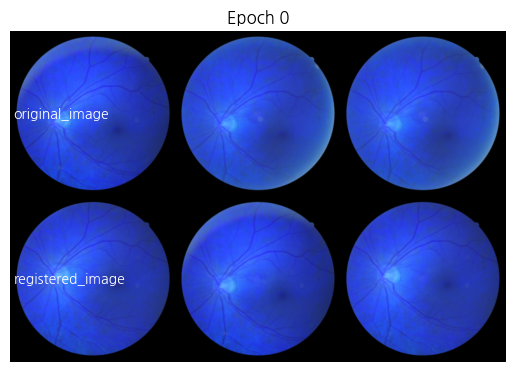

Epoch [0], Train Loss: -0.8288, Val Loss: -0.80866, Dice score: 0.04373


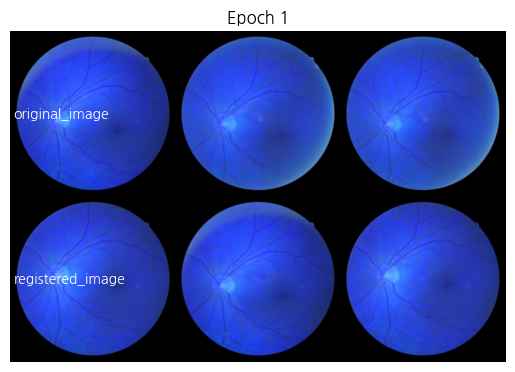

Epoch [1], Train Loss: -0.8288, Val Loss: -0.80866, Dice score: 0.48350


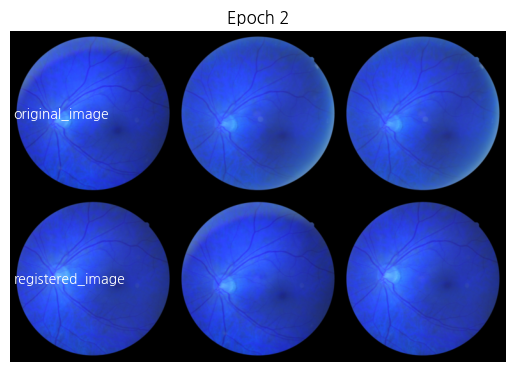

Epoch [2], Train Loss: -0.8288, Val Loss: -0.80866, Dice score: 0.43159


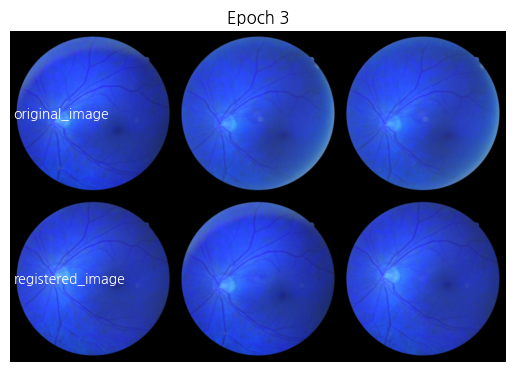

Epoch [3], Train Loss: -0.8288, Val Loss: -0.80866, Dice score: 0.38307


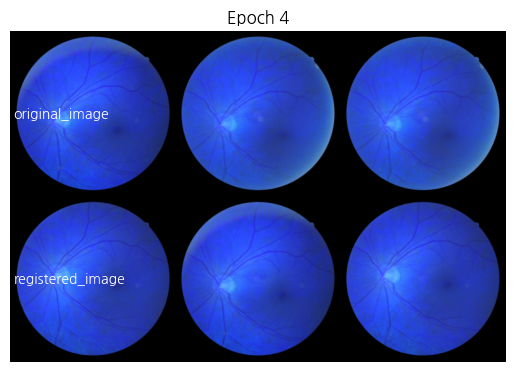

Epoch [4], Train Loss: -0.8288, Val Loss: -0.80866, Dice score: 0.41140


In [7]:
for epoch in range(EPOCHS):
    for i, (imgs, pairs) in enumerate(train_loader):
        imgs = imgs.float().to(device).permute(0,2,3,1)
        pairs = pairs.float().to(device).permute(0,2,3,1)
                
        model.zero_grad()
        registered_image = model(pairs, imgs)
                
        loss = vox_morph_loss(registered_image, imgs, 9 , 0.01)
        loss.backward()
        optimizer.step()
    dice_sc = dice_score(registered_image, imgs)

    if epoch%1==0:
        model.eval()
        val_loss = []
        preds, true_pairs = [], []
        with torch.no_grad():
            for imgs, pairs in test_loader:
                imgs = imgs.float().to(device).permute(0,2,3,1)
                pairs = pairs.float().to(device).permute(0,2,3,1)
                
                model.zero_grad()
                registered_image = model(pairs, imgs)
                loss = vox_morph_loss(registered_image, imgs, 9 , 0.01)
                
                val_loss.append(loss.item())
            
            _val_loss = np.mean(val_loss)
            
        imgs = imgs.permute(0,3,1,2)
        registered_image = registered_image.permute(0,3,1,2)
        merge_imgs = torch.cat([imgs, registered_image], axis=0)
        grid = vutils.make_grid(merge_imgs, nrow=3, padding=2, normalize=False)
        plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
        plt.text(5, 129, 'original_image', va='center', ha='left', color='white')
        plt.text(5, 129+258, 'registered_image', va='center', ha='left', color='white')
        plt.title(f"Epoch {epoch}")
        plt.axis('off')
        plt.show()
        print(f'Epoch [{epoch}], Train Loss: {loss.item():.4f}, Val Loss: {_val_loss:.5f}, Dice score: {dice_sc:.5f}')
